In [3]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from numpy import inf


class Line:
    """An object used to create a line from two points

    :param start: First point used to generate the line. It's an
                  array of form [x,y].
    :type start: numpy.ndarray
    :param end: Second point used to generate the line. It's an
                array of form [x,y].
    :type end: numpy.ndarray
    """
    def __init__(self, start: np.ndarray, end: np.ndarray):
        if np.shape(start)!= (2,):
            raise ValueError("Start point must have the shape (2,)")
        if np.shape(end) != (2,):
            raise ValueError("End point must have the shape (2,)")
        if (start==end).all():
            raise ValueError("Start and end points must be different")
        
        # Calculate useful properties of the line
        self.start = start
        self.line = end - start
        self.length = np.linalg.norm(self.line)
        self.unit_line = self.line / self.length
        
    def point_dist(self, point: np.ndarray):
        """Calculate the distance between a point and a line segment.
        adapted from code given by clued__init__ found here:
        https://www.py4u.net/discuss/186227

        To calculate the closest distance to a line, we calculate
        the orthogonal distance from the point to the line.

        :param point: Numpy array of form [x,y], describing the point.
        :type point: numpy.ndarray
        :return: The minimum distance to a point.
        :rtype: float
        """
        if np.shape(point)!= (2,):
            raise ValueError("Start point must have the shape (2,)")
        # compute the perpendicular distance to the theoretical infinite line
        return np.linalg.norm(np.cross(self.line, self.start - point)) /self.length
    
    def equation(self):
        """Calculate the basic linear equation parameters useful for plotting

        :return: (m, c) where m is the gradient of the line
                 and c is the y intercept
        :rtype: tuple of floats
        """
        # adding 1e-5 to handle cases where self.line[0] is zero
        m = self.line[1]/(self.line[0]+1e-5)
        c = self.start[1] - m*self.start[0]
        return (m, c)

In [4]:
def np_polar2cart(polar_points):
    center = np.array([0,0])
    r = polar_points.T[0,]
    theta = polar_points.T[1,]
    x = r*np.cos(theta) # theta -> radians
    y = r*np.sin(theta)
    return np.array([x, y]).T 

def reduction_filter(data_points, sigma, rf_max_pts):

    '''
    Method to reduce number of laser scan points by replacing cluster of points
    with their representative.
    :param data_points: 2D array representing laser scan data in cartesian coordinates
    :param type: np.ndarray
    :param sigma: maximum distance between two consecutive points to consider them 
    in same cluster
    :param type: float    
    :param rf_max_pts: maximum number of points allowed in a cluster
    :param type: int    
    '''
    points_list = list(data_points)
    output = []
    while len(points_list) > 0:
        a_i = points_list.pop(0)
        cur_sum = np.array(a_i)
        i = 1
        while len(points_list) > 0 and abs(a_i[0] - points_list[0][0]) < sigma \
        and i <= rf_max_pts:
            cur_sum += np.array(points_list.pop(0))
            i += 1
        output.append(cur_sum/i)
    return np.array(output)


In [5]:
def process_data(range_data: np.ndarray, max_angle: float, min_angle: float, max_range: float, min_range: float, sigma: float, rf_max_pts: int, reduce_bool: bool=True):
	"""
	Filter data by removing all perceived points outside defined boundary
	"""

	angles = np.linspace(min_angle,max_angle,range_data.shape[0])
	processed_data = np.array([range_data,angles]).T # np_polar2cart(np.array([range_data,angles]).T)
	out_of_min_range = np.where(range_data<min_range)[0]
	out_of_max_range = np.where(range_data>max_range)[0]
	processed_data = np.delete(processed_data, np.concatenate([out_of_max_range,out_of_min_range]), axis=0)
	processed_data = np_polar2cart(processed_data)
	if reduce_bool:
		processed_data = reduction_filter(data_points=processed_data, sigma=sigma, rf_max_pts=rf_max_pts)
            
	return processed_data

def points_to_line_new(desired_wall, step=1):
    m, c = np.polyfit(desired_wall[:,0], desired_wall[:,1], 1)
    lims = [desired_wall[0,0], desired_wall[-1,0]]
    lims.sort()
    x_min, x_max = tuple(lims)
    x = np.arange(x_min, x_max+step, step)
    y = m*x+c
    return np.array([x, y])

In [6]:
def online_line_detection_new(points, e=0.1, incr=0.01, max_dist=5, k=5):
    """
    arguments:
    points  : ordered list of arrays of individual points
    e       : allowed fraction of deviation of sum of distances between consecutive points and 
    the total length  of the line
    incr    : increment in the error values with the number of points
    max_dist: maximum distance between consecutive points allowed in a line segment
    k       : minimum number of points required in a line segment
    return: return a list of numpy array containing points grouped into points on the same line
    """
    grouped_points = []
    
    point = points[0]
    current_group = [point]
    aj = point              # starting point of current line segment
    dist_sum = 0            # sum of distances between consecutive points in a line segment
    ak = point              # latest point added to a line
    ek = e                  # incremented error

    for point_idx in range(1,len(points)): 
        dist_sum += np.linalg.norm(ak-points[point_idx])

        # getting ratio between distance b/w first and last point to the sum of distances b/w consecutive points
        full_dist_ratio = np.linalg.norm(aj-points[point_idx])/dist_sum

        # end_dist_ratio is the ratio of distance b/w previous point and new point to the sum of distance b/w
        # privious, current and new point. It is set to 1 until minimum number required in a line is obtained
        end_dist_ratio = 1 
        
        if len(current_group) >= k:
            prev_ak = points[point_idx-2]
            end_dist_ratio = np.linalg.norm(prev_ak-points[point_idx])/ (np.linalg.norm(prev_ak-ak)+np.linalg.norm(ak-points[point_idx]))
        
        if(full_dist_ratio > 1-ek and end_dist_ratio > 1-e and np.linalg.norm(ak-points[point_idx]) <= max_dist):
            current_group.append(points[point_idx])
            ak = points[point_idx]
            ek += incr

        else:
            if len(current_group) >= k:
                grouped_points.append(np.array(current_group))
                
            current_group = [points[point_idx]]
            aj = points[point_idx]
            dist_sum = 0
            ak = points[point_idx]
            ek = e
            
    if len(current_group) >= k:
        grouped_points.append(np.array(current_group))
        # print("grouped_points",grouped_points)

    print('grouped_points', grouped_points)
    return grouped_points

In [7]:
def RANSAC_get_line_params(points: list, dist_thresh: int, iterations: int, thresh_count: int):
    
    d_m_c_endPts = [] # d: perpendicular distance, m: slope, c: constant in line equation
    while True:
        params = RANSAC(points, dist_thresh, iterations, thresh_count)
        if params:
            p1, p2, best_inliers = params
            # dtype(best_inliers): list of array of individual points
        else:
            break

        # updating points list by removing all inliers that were found
        for point in best_inliers:
            points = [x for x in points if not (x == point).all()]
        best_line = Line(p1, p2)
        m, c = best_line.equation()

        # getting starting and end points of individual lines
        best_inliers_arr = np.array(best_inliers)
        min_x, max_x = min(best_inliers_arr[:, 0]), max(best_inliers_arr[:, 0])
        min_y, max_y = min(best_inliers_arr[:, 1]), max(best_inliers_arr[:, 1])
        # each row of end_points consists of 'x' and 'y' coordinates
        if abs(min_x-max_x) >= abs(min_y-max_y):
            end_points = np.array([[min_x, m*min_x+c], [max_x, m*max_x+c]])
        else:
            end_points = np.array(
                [[(min_y-c)/m, min_y], [(max_y-c)/m, max_y]])

        center_wrt_laser = np.array([-0.45, 0]) # location of center of robot w.r.t. laser scanner
        d = best_line.point_dist(center_wrt_laser) # distance fom the center of the Robile
        d_m_c_endPts.append([d, m, c, end_points]) 
    return d_m_c_endPts


def RANSAC(points: list, dist_thresh: int, iterations: int, thresh_count: int):

	if len(points) == 0:
		return False 
	  
	indexes = list(range(0, len(points)))
	inliers = dict()
	for _ in range(0,iterations):
		sample_points = indexes.copy()
		random.shuffle(sample_points)
		start = sample_points.pop()
		end = sample_points.pop()

		if((start,end) not in inliers) and ((end,start) not in inliers):
			inliers[(start,end)]=[]
			line = Line(points[start],points[end])
			for point_idx in sample_points:
				if line.point_dist(points[point_idx]) < dist_thresh:
					inliers[(start,end)].append(points[point_idx])

	best_pair = None

	for cur_pair in inliers:
		if best_pair == None:
			best_pair = cur_pair
		elif len(inliers[cur_pair]) > len(inliers[best_pair]):
			best_pair = cur_pair
             
	if len(inliers[best_pair]) < thresh_count:
		return False
	best_point_1 = points[best_pair[0]]
	best_point_2 = points[best_pair[1]]        
	return best_point_1, best_point_2, inliers[best_pair]

In [8]:
def plotgen(laser_scan,title, algorithm="online"):
    temp = np.array(laser_scan)
    temp = np.nan_to_num(temp, nan=5)
    max_angle= 1.5707963267948966
    min_angle= -1.5707963267948966
    max_range= 25.0
    min_range= 0.05
    sigma= 0.2
    rf_max_pts= 10
    reduce_bool= True

    # RANSAC
    distance_threshold = 0.15
    iterations = 20
    minimum_cout_of_points = 5
    


    # print('laser_scan', temp)
    filtered_data = process_data(range_data= temp, max_angle=max_angle,
                        min_angle= min_angle, max_range= max_range,
                        min_range=min_range, sigma=sigma,
                        rf_max_pts=rf_max_pts, reduce_bool= reduce_bool)
    d_m_c_endPts = []
    # print('desired_wall', desired_wall)
    if algorithm=="online":
        grouped_points = online_line_detection_new(filtered_data)
        
        line_lengths = []
        if grouped_points:
            for points_on_line in grouped_points:
                line_segment = Line(points_on_line[0], points_on_line[-1])
                end_pts = np.array([points_on_line[0], points_on_line[-1]])
                print("end-points: ", end_pts)
                m, c = line_segment.equation()
                center_wrt_laser = np.array([-0.45, 0])       # location of center of robot with respect to laser scanner
                d = line_segment.point_dist(center_wrt_laser) # distance fom the center of the Robile
                length = np.linalg.norm(end_pts[1] - end_pts[0])
                line_lengths.append(length)
                d_m_c_endPts.append([d, m, c, end_pts])
            best_line = np.max(line_lengths)
            best_line_idx = line_lengths.index(best_line)
    elif algorithm=="ransac":
        print("in ransac")
        d_m_c_endPts = RANSAC_get_line_params(filtered_data, distance_threshold , iterations, minimum_cout_of_points)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    for line_params in d_m_c_endPts:
        plt.plot(line_params[-1][:,0], line_params[-1][:,1])

    # for line_points in grouped_points:
    #     line = points_to_line_new(line_points)
    #     plt.plot(line[0], line[1])

    plt.scatter(filtered_data[:,0], filtered_data[:,1])
    plt.title("Online Line detection: "+ title)
    plt.xlabel("x position")
    plt.ylabel("y position")
    plt.axis("equal")
    plt.grid()
    plt.show()

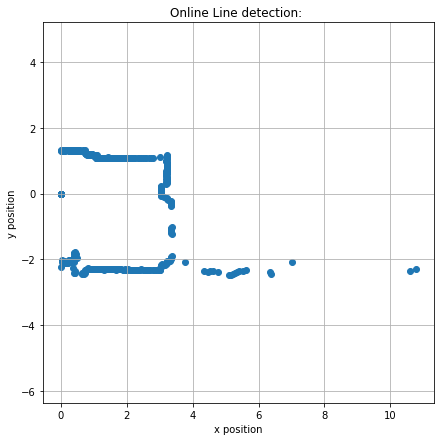

In [9]:
data = abs(np.loadtxt("./laser_data3.csv"))
angles = np.linspace(-1.57, 1.57,data.shape[0])
processed_data = np.array([data,angles]).T
processed_data = np_polar2cart(processed_data)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

plt.scatter(processed_data[:,0], processed_data[:,1])
plt.title("Online Line detection: ")
plt.xlabel("x position")
plt.ylabel("y position")
plt.axis("equal")
plt.grid()
plt.show()

grouped_points [array([[ 0.92410992, -2.28574612],
       [ 1.13122777, -2.29244927],
       [ 1.33964467, -2.29611451],
       [ 1.55287375, -2.30104185],
       [ 1.77135531, -2.30730595],
       [ 1.99193281, -2.31079044],
       [ 2.21734033, -2.31530174],
       [ 2.44530923, -2.31970339],
       [ 2.64697082, -2.32083782],
       [ 2.85434761, -2.33155751],
       [ 3.05740621, -2.22111756],
       [ 3.29166701, -2.01674726],
       [ 3.76873633, -2.08904466],
       [ 4.44013886, -2.36037613],
       [ 4.69495624, -2.36604476],
       [ 5.19061962, -2.44754137],
       [ 5.36967586, -2.3625733 ],
       [ 5.57424734, -2.3373174 ],
       [ 6.36301549, -2.41088723]]), array([[3.00671776, 1.12416571],
       [2.73455376, 1.07680046],
       [2.5191782 , 1.08176756],
       [2.29609205, 1.08228017],
       [2.08626963, 1.08517356],
       [1.88340321, 1.08671832],
       [1.68087514, 1.0803279 ],
       [1.46395118, 1.08184738],
       [1.23232641, 1.0793629 ],
       [1.06299369, 

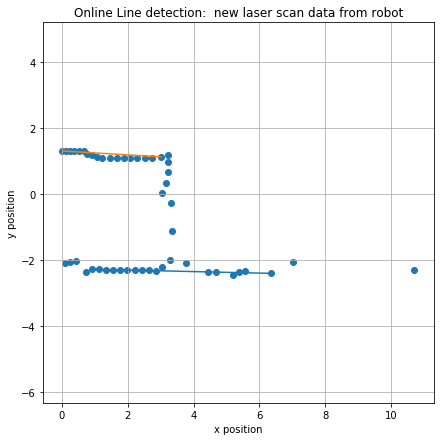

In [10]:
data = np.loadtxt("./laser_data3.csv")
data = np.abs(data)
plotgen(data," new laser scan data from robot", "online")

in ransac


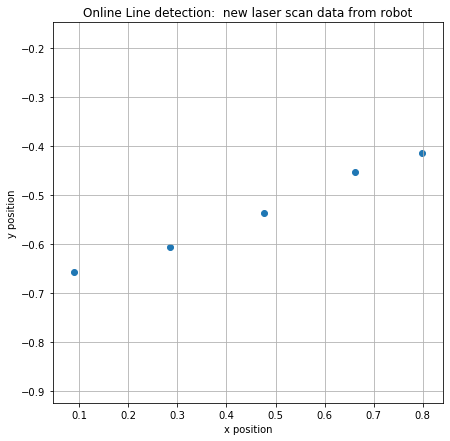

In [12]:
data = np.loadtxt("./random.csv")
data = np.abs(data)
plotgen(data," new laser scan data from robot", "ransac")

grouped_points [array([[ 0.60959035, -1.51358904],
       [ 0.69393922, -1.48815746],
       [ 1.45676027, -2.88896873],
       [ 1.67400837, -2.92784914],
       [ 1.88807289, -2.96288498],
       [ 2.11550269, -3.01985127],
       [ 2.33564443, -3.04310562],
       [ 2.53860866, -3.05137621],
       [ 2.75994563, -3.09159274]]), array([[ 0.68174504, -0.70107095],
       [ 0.43369466, -0.38409457],
       [ 0.44162906, -0.32117111],
       [ 0.45746269, -0.26957012],
       [ 0.46218907, -0.2155617 ],
       [ 0.47663836, -0.1687394 ],
       [ 0.49206229, -0.12247975]]), array([[ 0.64727837, -0.09681339],
       [ 0.65403367, -0.03429393],
       [ 0.65957434,  0.02881828],
       [ 0.67436983,  0.09488623],
       [ 0.6839713 ,  0.16443293],
       [ 0.70088067,  0.24160603],
       [ 0.71664965,  0.32693164],
       [ 0.7344501 ,  0.42470537],
       [ 0.75304299,  0.53797529],
       [ 0.76464596,  0.66662926],
       [ 0.73792607,  0.776652  ]]), array([[0.61714149, 0.78913597],


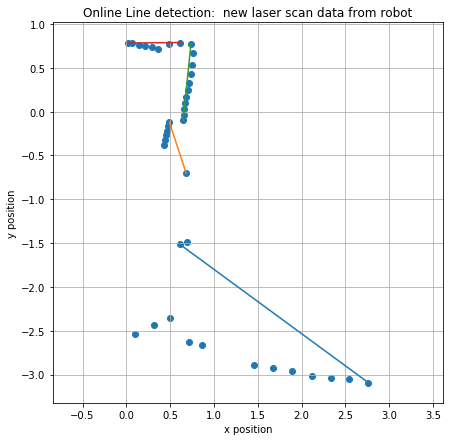

In [ ]:
data=np.array([2.63100004196167, 2.6050000190734863, 2.623000144958496, 2.63100004196167, 2.51200008392334, 2.454000234603882, 2.4740002155303955, 2.4630000591278076, 2.4790000915527344, 2.497000217437744, 2.4870002269744873, 2.504000186920166, 2.495000123977661, 2.507000207901001, 2.4160001277923584, 2.4140000343322754, 2.430000066757202, 2.452000141143799, 2.438000202178955, 2.446000099182129, 2.3950002193450928, 2.382000207901001, 2.3400001525878906, 2.311000108718872, 2.321000099182129, 2.4000000953674316, 2.5220000743865967, 2.561000108718872, 2.634000062942505, 2.6590001583099365, 2.677000045776367, 2.700000047683716, 2.760000228881836, 2.9020001888275146, 2.953000068664551, 2.9660000801086426, 2.9840002059936523, 2.995000123977661, 2.1130001544952393, 1.8220001459121704, 1.6770000457763672, 1.6190000772476196, 1.717000126838684, 1.75600004196167, 1.5530000925064087, 1.5450000762939453, 1.527000069618225, 1.564000129699707, 1.5730000734329224, 1.6030000448226929, 1.6420000791549683, 3.195000171661377, 3.19100022315979, 3.2190001010894775, 3.255000114440918, 3.263000249862671, 3.2920000553131104, 3.32200026512146, 3.3340001106262207, 3.372000217437744, 3.384000062942505, 3.4040000438690186, 3.4220001697540283, 3.455000162124634, 3.507000207901001, 3.509000062942505, 3.5320000648498535, 3.565000057220459, 3.5990002155303955, 3.617000102996826, 3.7100002765655518, 3.747000217437744, 3.764000177383423, 3.7800002098083496, 3.809000253677368, 3.8450002670288086, 3.8600001335144043, 3.888000249862671, 3.891000270843506, 3.931000232696533, 3.998000144958496, 4.058000087738037, 4.085000038146973, 4.12600040435791, 4.1570000648498535, 4.210000038146973, 1.0509999990463257, 1.0190000534057617, 0.984000027179718, 0.9970000386238098, 0.9880000352859497, 0.8290000557899475, 0.5850000381469727, 0.5950000286102295, 0.5840000510215759, 0.5940000414848328, 0.5850000381469727, 0.5860000252723694, 0.5790000557899475, 0.5840000510215759, 0.5760000348091125, 0.5520000457763672, 0.5550000071525574, 0.5680000185966492, 0.5410000085830688, 0.5530000329017639, 0.5630000233650208, 0.5540000200271606, 0.5450000166893005, 0.5460000038146973, 0.5270000100135803, 0.550000011920929, 0.5320000052452087, 0.5300000309944153, 0.5330000519752502, 0.5460000038146973, 0.5260000228881836, 0.531000018119812, 0.5290000438690186, 0.5240000486373901, 0.5290000438690186, 0.5440000295639038, 0.5430000424385071, 0.531000018119812, 0.5070000290870667, 0.5170000195503235, 0.5130000114440918, 0.5100000500679016, 0.5120000243186951, 0.5250000357627869, 0.49800002574920654, 0.5, 0.5080000162124634, 0.49000000953674316, 0.5100000500679016, 0.5290000438690186, 0.4910000264644623, 0.5049999952316284, 0.5170000195503235, 0.5200000405311584, 0.5060000419616699, 0.5040000081062317, 0.4870000183582306, 0.5, 0.5080000162124634, 0.5130000114440918, 0.5130000114440918, 0.5090000033378601, 0.4870000183582306, 0.51500004529953, 0.5110000371932983, 0.5, 0.49500003457069397, 0.49900001287460327, 0.4960000216960907, 0.5049999952316284, 0.5100000500679016, 0.5530000329017639, 0.6570000052452087, 0.6600000262260437, 0.6520000100135803, 0.6570000052452087, 0.6580000519752502, 0.6650000214576721, 0.6460000276565552, 0.6540000438690186, 0.656000018119812, 0.6500000357627869, 0.6470000147819519, 0.6580000519752502, 0.6500000357627869, 0.6630000472068787, 0.6540000438690186, 0.6490000486373901, 0.6680000424385071, 0.6550000309944153, 0.6470000147819519, 0.6470000147819519, 0.656000018119812, 0.6600000262260437, 0.6630000472068787, 0.6520000100135803, 0.656000018119812, 0.656000018119812, 0.6710000038146973, 0.6650000214576721, 0.6650000214576721, 0.6580000519752502, 0.6570000052452087, 0.6620000600814819, 0.6600000262260437, 0.6800000071525574, 0.6850000619888306, 0.6650000214576721, 0.6790000200271606, 0.6770000457763672, 0.675000011920929, 0.6950000524520874, 0.6730000376701355, 0.6850000619888306, 0.6890000104904175, 0.6910000443458557, 0.6970000267028809, 0.6940000057220459, 0.6860000491142273, 0.7010000348091125, 0.6940000057220459, 0.7070000171661377, 0.718000054359436, 0.7080000042915344, 0.7000000476837158, 0.7220000624656677, 0.7140000462532043, 0.7170000076293945, 0.7390000224113464, 0.7240000367164612, 0.7480000257492065, 0.7390000224113464, 0.7380000352859497, 0.7350000143051147, 0.7640000581741333, 0.7590000629425049, 0.7410000562667847, 0.7540000081062317, 0.7630000114440918, 0.7830000519752502, 0.7850000262260437, 0.781000018119812, 0.7820000648498535, 0.7770000100135803, 0.7850000262260437, 0.8030000329017639, 0.800000011920929, 0.8050000667572021, 0.8040000200271606, 0.812000036239624, 0.8100000619888306, 0.8440000414848328, 0.8350000381469727, 0.8490000367164612, 0.8390000462532043, 0.8570000529289246, 0.8630000352859497, 0.8870000243186951, 0.8610000610351562, 0.8790000677108765, 0.8760000467300415, 0.8970000147819519, 0.9080000519752502, 0.9040000438690186, 0.9080000519752502, 0.9380000233650208, 0.9490000605583191, 0.9410000443458557, 0.9650000333786011, 0.9510000348091125, 0.9470000267028809, 0.9290000200271606, 0.9330000281333923, 0.9540000557899475, 1.002000093460083, 1.0049999952316284, 1.0240000486373901, 1.0360000133514404, 1.0480000972747803, 1.0700000524520874, 1.065000057220459, 1.097000002861023, 1.1080000400543213, 1.1160000562667847, 1.0860000848770142, 1.090000033378601, 1.0760000944137573, 1.0770000219345093, 1.0490000247955322, 1.0490000247955322, 1.0480000972747803, 1.055999994277954, 1.034000039100647, 1.0470000505447388, 1.0170000791549683, 1.0230000019073486, 1.0049999952316284, 1.0040000677108765, 0.999000072479248, 0.9910000562667847, 0.9810000658035278, 0.984000027179718, 0.9810000658035278, 0.9920000433921814, 0.9620000720024109, 0.9860000610351562, 0.956000030040741, 0.9670000672340393, 0.9740000367164612, 0.9620000720024109, 0.9280000329017639, 0.8540000319480896, 0.8230000138282776, 0.8250000476837158, 0.8130000233650208, 0.8050000667572021, 0.8090000152587891, 0.815000057220459, 0.8330000638961792, 0.815000057220459, 0.7980000376701355, 0.8200000524520874, 0.7930000424385071, 0.7910000085830688, 0.7970000505447388, 0.7970000505447388, 0.7870000600814819, 0.8170000314712524, 0.781000018119812, 0.7920000553131104, 0.7940000295639038, 0.7860000133514404, 0.7800000309944153, 0.8100000619888306, 0.7740000486373901, 0.7870000600814819, 0.7750000357627869, 0.7700000405311584, 0.781000018119812, 0.7710000276565552, 0.7880000472068787, 0.7940000295639038, 0.7770000100135803, 0.7800000309944153, 0.7740000486373901, 0.7750000357627869, 0.7620000243186951, 0.7920000553131104, 0.7690000534057617, 0.7740000486373901, 0.7770000100135803, 0.7870000600814819, 0.7850000262260437, 0.7900000214576721, 0.7830000519752502, 0.7830000519752502, 0.7830000519752502, 0.7740000486373901, 0.7740000486373901, 0.7880000472068787, 0.7710000276565552, 0.7940000295639038, 0.7920000553131104, 0.7720000147819519, 0.7730000615119934, 0.796000063419342, 0.7740000486373901, 0.7740000486373901, 0.7750000357627869, 0.796000063419342, 0.7800000309944153, 0.7830000519752502, 0.7790000438690186, 0.7800000309944153, 0.7940000295639038])
plotgen(data," new laser scan data from robot", "online")
